<a href="https://colab.research.google.com/github/zhou100/FoodSecurityPrediction/blob/master/PredictFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use machine learning to predict food security

In [0]:
# Set up Notebook
% matplotlib inline

# Standard imports
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

 ## Read in the data cleaned out by R

If you are using google colab like me, you will need to mount your google drive first and  copy the cleaned dataset from the R project to your google drive. 

If you are using python/jupyter notebook locally, just point to the right directory. 

In [38]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!cp /gdrive/My\ Drive/Colab\ Notebooks/fs_data/mw_dataset_hh.csv ./
!cp /gdrive/My\ Drive/Colab\ Notebooks/fs_data/mw_dataset_cluster.csv ./
!cp /gdrive/My\ Drive/Colab\ Notebooks/fs_data/tz_dataset_hh.csv ./
!cp /gdrive/My\ Drive/Colab\ Notebooks/fs_data/tz_dataset_cluster.csv ./
!cp /gdrive/My\ Drive/Colab\ Notebooks/fs_data/ug_dataset_hh.csv ./
!cp /gdrive/My\ Drive/Colab\ Notebooks/fs_data/ug_dataset_cluster.csv ./

**Read the csv data copied from google drive **

In [0]:
mw_hh = pd.read_csv("mw_dataset_hh.csv")
mw_clust = pd.read_csv("mw_dataset_cluster.csv")
tz_hh = pd.read_csv("tz_dataset_hh.csv")
tz_clust = pd.read_csv("tz_dataset_cluster.csv")
ug_hh = pd.read_csv("ug_dataset_hh.csv")
ug_clust = pd.read_csv("ug_dataset_cluster.csv")


## Preprocessing data


### Remove rows of missing values or extreme values

In [0]:
# no missing values 
tz_clust = tz_clust.loc[(tz_clust['FCS']!=0) & (tz_clust['HDDS']!=0)]
tz_hh = tz_hh.loc[(tz_hh['FCS']!=0 )& tz_hh['HDDS']!=0]
ug_clust = ug_clust.loc[(ug_clust['FCS']!=0) & (ug_clust['HDDS']!=0)]
ug_hh = ug_hh.loc[(ug_hh['FCS']!=0) & (ug_hh['HDDS']!=0)]


### One-hot encoding for string variables 

In [0]:
mw_hh["FNID"]= mw_hh["FNID"].str.lstrip('MW2012C')
fnid_mw_hh = pd.get_dummies(mw_hh["FNID"],prefix='MW', drop_first=True)
mw_hh = pd.concat([mw_hh, fnid_mw_hh], axis=1)

mw_clust["FNID"]= mw_clust["FNID"].str.lstrip('MW2012C')
fnid_mw_clust = pd.get_dummies(mw_clust["FNID"],prefix='MW', drop_first=True)
mw_clust = pd.concat([mw_clust, fnid_mw_clust], axis=1)



gender_mw_hh = pd.get_dummies(mw_hh["head_gender"],prefix='gender', drop_first=True)
mw_hh = pd.concat([mw_hh, gender_mw_hh], axis=1)

edu_mw_hh = pd.get_dummies(mw_hh["head_edlevel"],prefix='edu', drop_first=True)
mw_hh = pd.concat([mw_hh, edu_mw_hh], axis=1)


mw_hh = mw_hh.drop(["head_gender","head_edlevel"],axis =1)





In [0]:
tz_hh["FNID"]= tz_hh["FNID"].str.lstrip('TZ2009L')
fnid_tz_hh = pd.get_dummies(tz_hh["FNID"],prefix='TZ', drop_first=True)
tz_hh = pd.concat([tz_hh, fnid_tz_hh], axis=1)
tz_hh = tz_hh.drop(["FNID"],axis =1)


tz_clust["FNID"]= tz_clust["FNID"].str.lstrip('TZ2009L')
fnid_tz_clust = pd.get_dummies(tz_clust["FNID"],prefix='TZ', drop_first=True)
tz_clust = pd.concat([tz_clust, fnid_tz_clust], axis=1)
tz_clust = tz_clust.drop(["FNID"],axis =1)

In [0]:
ug_hh["FNID"]= ug_hh["FNID"].str.lstrip('UG2011L')
fnid_ug_hh = pd.get_dummies(ug_hh["FNID"],prefix='UG', drop_first=True)
ug_hh = pd.concat([ug_hh, fnid_ug_hh], axis=1)
ug_hh = ug_hh.drop(["FNID"],axis =1)


ug_clust["FNID"]= ug_clust["FNID"].str.lstrip('UG2011L')
fnid_ug_clust = pd.get_dummies(ug_clust["FNID"],prefix='UG', drop_first=True)
ug_clust = pd.concat([ug_clust, fnid_ug_clust], axis=1)
ug_clust = ug_clust.drop(["FNID"],axis =1)

In [0]:
mw_hh = mw_hh.drop(["ea_id"],axis=1)
tz_hh = tz_hh.drop(["yearmon"],axis=1)
tz_clust = tz_clust.drop(["yearmon"],axis=1)

ug_hh = ug_hh.drop(["yearmon"],axis=1)
ug_clust = ug_clust.drop(["yearmon"],axis=1)


### Impute missing values and standarize variables 

In [0]:
from sklearn.preprocessing import StandardScaler

#ss = StandardScaler()

#mw_hh_X_train = ss.fit_transform(mw_hh_X_train)
#mw_hh_X_test = ss.fit_transform(mw_hh_X_test)
#tz_hh_X_train = ss.fit_transform(tz_hh_X_train)
#tz_hh_X_test = ss.fit_transform(tz_hh_X_test)
#ug_hh_X_train = ss.fit_transform(ug_hh_X_train)
#ug_hh_X_test = ss.fit_transform(ug_hh_X_test)

#mw_clust_X_train = ss.fit_transform(mw_clust_X_train)
#mw_clust_X_test = ss.fit_transform(mw_clust_X_test)
#tz_clust_X_train = ss.fit_transform(tz_clust_X_train)
#tz_clust_X_test = ss.fit_transform(tz_clust_X_test)
#ug_clust_X_train = ss.fit_transform(ug_clust_X_train)
#ug_clust_X_test = ss.fit_transform(ug_clust_X_test)



## Exploratory Data Analysis  

### Measures:  plot target measures by year by country


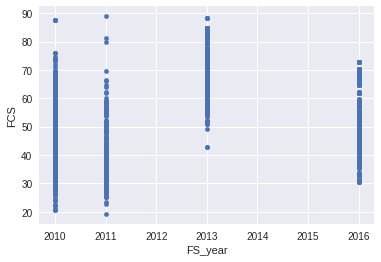

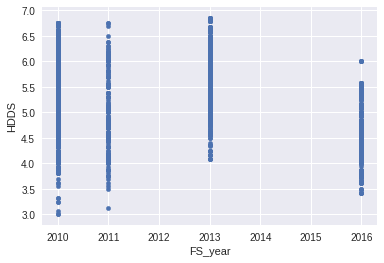

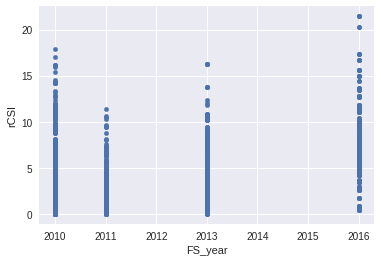

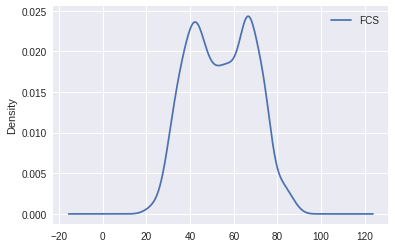

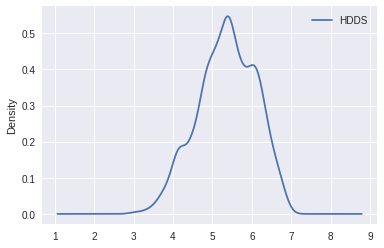

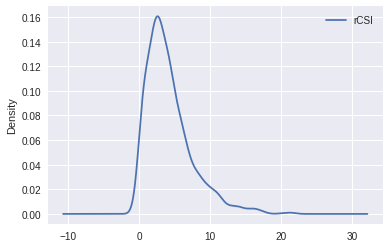

In [47]:
mw_clust.plot.scatter(x='FS_year', y='FCS')
mw_clust.plot.scatter(x='FS_year', y='HDDS')
mw_clust.plot.scatter(x='FS_year', y='rCSI')

mw_clust.plot.density(y='FCS')
mw_clust.plot.density(y='HDDS')
mw_clust.plot.density(y='rCSI')


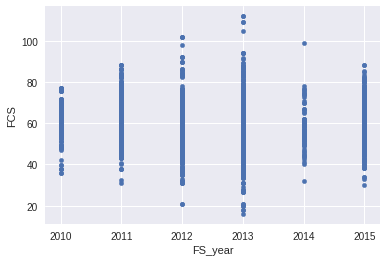

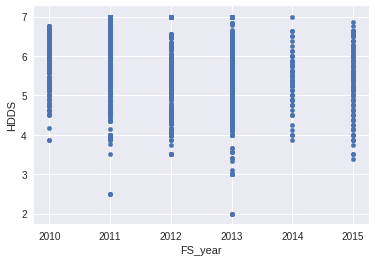

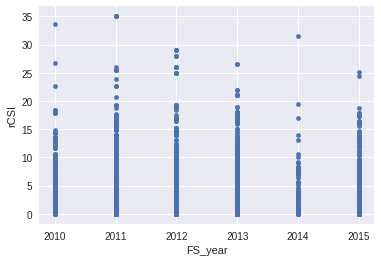

In [48]:
tz_clust.plot.scatter(x='FS_year', y='FCS')
tz_clust.plot.scatter(x='FS_year', y='HDDS')
tz_clust.plot.scatter(x='FS_year', y='rCSI')

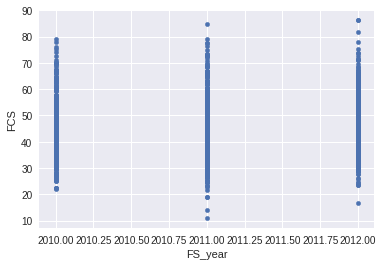

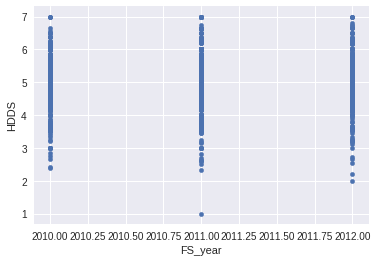

In [49]:
ug_clust.plot.scatter(x='FS_year', y='FCS')
ug_clust.plot.scatter(x='FS_year', y='HDDS')


### Asset related

### Weather

### Market Prices 

## Modelling


### Split train and test data

 For practical prediction purposes,  we use the most recent round of survey data  as the testing  and the rest as the training data. 


In [50]:
mw_hh['FS_year'].unique()

array([2010, 2011, 2013, 2016])

In [0]:
# separate test and training for mw

mw_hh_test_cond =  mw_hh['FS_year']>2015
mw_hh_train_cond =  mw_hh['FS_year']<2016
mw_hh_test = mw_hh[mw_hh_test_cond]
mw_hh_train = mw_hh[mw_hh_train_cond]

mw_clust_test_cond =  mw_clust['FS_year']>2015
mw_clust_train_cond =  mw_clust['FS_year']<2016
mw_clust_test = mw_clust[mw_clust_test_cond]
mw_clust_train = mw_clust[mw_clust_train_cond]



In [52]:
tz_hh['FS_year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015])

In [53]:
ug_clust['FS_year'].unique()

array([2011, 2012, 2010])

In [0]:
# separate test and training for tz

tz_hh_test_cond =  tz_hh['FS_year']>2013
tz_hh_train_cond =  tz_hh['FS_year']<2014
tz_hh_test = tz_hh[tz_hh_test_cond]
tz_hh_train = tz_hh[tz_hh_train_cond]

tz_clust_test_cond =  tz_clust['FS_year']>2013
tz_clust_train_cond =  tz_clust['FS_year']<2014
tz_clust_test = tz_clust[tz_clust_test_cond]
tz_clust_train = tz_clust[tz_clust_train_cond]


In [55]:
ug_hh['FS_year'].unique()
#ug_hh[ug_hh['FS_year']==2012].shape #3531 of tesing 
#ug_hh[ug_hh['FS_year']!=2012].shape #7372 of tesing 


array([2012, 2011, 2010])

In [0]:
# separate test and training for ug 
ug_hh_test_cond =  ug_hh['FS_year']>2011
ug_hh_train_cond =  ug_hh['FS_year']<2012
ug_hh_test = ug_hh[ug_hh_test_cond]
ug_hh_train = ug_hh[ug_hh_train_cond]

ug_clust_test_cond =  ug_clust['FS_year']>2011
ug_clust_train_cond =  ug_clust['FS_year']<2012
ug_clust_test = ug_clust[ug_clust_test_cond]
ug_clust_train = ug_clust[ug_clust_train_cond]


**Separate the target/labels from the X variables. **

In [0]:
labels = ['FCS', 'rCSI', 'HDDS']

mw_hh_y_train= mw_hh_train[labels]
mw_hh_y_test= mw_hh_test[labels]
tz_hh_y_train= tz_hh_train[labels]
tz_hh_y_test= tz_hh_test[labels]

mw_clust_y_train= mw_clust_train[labels]
mw_clust_y_test= mw_clust_test[labels]
tz_clust_y_train= tz_clust_train[labels]
tz_clust_y_test= tz_clust_test[labels]



In [0]:
ug_labels = ['FCS', 'HDDS']

ug_hh_y_train= ug_hh_train[ug_labels]
ug_hh_y_test= ug_hh_test[ug_labels]
 
ug_clust_y_train= ug_clust_train[ug_labels]
ug_clust_y_test= ug_clust_test[ug_labels]



In [0]:
# Define the X variables from each country, in both training and testing.
mw_hh_X_train= mw_hh_train.drop(labels, axis=1)
mw_clust_X_train= mw_clust_train.drop(labels, axis=1)
tz_hh_X_train= tz_hh_train.drop(labels, axis=1)
tz_clust_X_train= tz_clust_train.drop(labels, axis=1)
ug_hh_X_train= ug_hh_train.drop(ug_labels, axis=1)
ug_clust_X_train= ug_clust_train.drop(ug_labels, axis=1)

mw_hh_X_test= mw_hh_test.drop(labels, axis=1)
mw_clust_X_test= mw_clust_test.drop(labels, axis=1)
tz_hh_X_test= tz_hh_test.drop(labels, axis=1)
tz_clust_X_test= tz_clust_test.drop(labels, axis=1)
ug_hh_X_test= ug_hh_test.drop(ug_labels, axis=1)
ug_clust_X_test= ug_clust_test.drop(ug_labels, axis=1)


In [60]:
mw_hh_X_test.shape

(9953, 114)

In [61]:
mw_hh_X_train.shape

(38145, 114)

In [0]:
X_train_list = [mw_hh_X_train,mw_clust_X_train,tz_hh_X_train,tz_clust_X_train,ug_hh_X_train,ug_clust_X_train]

X_test_list = [mw_hh_X_test,mw_clust_X_test,tz_hh_X_test,tz_clust_X_test,ug_hh_X_test,ug_clust_X_test]

y_train_list = [mw_hh_y_train,mw_clust_y_train,tz_hh_y_train,tz_clust_y_train,ug_hh_y_train,ug_clust_y_train]

y_test_list = [mw_hh_y_test,mw_clust_y_test,tz_hh_y_test,tz_clust_y_test,ug_hh_y_test,ug_clust_y_test]

column_names = ["dataset","FCS","HDDS","rCSI"]

name_list = ["Malawi_household","Malawi_cluster","Tanzania_household","Tanzania_cluster","Uganda_household","Uganda_cluster"]

In [63]:
ug_hh_X_train.isna().sum().sum()

0

### Models

In [0]:
# define a function that displays multiple results at the same time as a table
# input will be function and a character list
  
  def result_table(function,column_names=column_names):
    
    result_table = pd.DataFrame(columns=column_names)
    
    for index in range(len(X_train_list)):
      fcs_value = function(X_train_list[index],X_test_list[index],y_train_list[index]["FCS"],y_test_list[index]["FCS"])
      hdds_value = function(X_train_list[index],X_test_list[index],y_train_list[index]["HDDS"],y_test_list[index]["HDDS"])
      if index<4:
        rcsi_value = function(X_train_list[index],X_test_list[index],y_train_list[index]["rCSI"],y_test_list[index]["rCSI"])
      else:
        rcsi_value = 0
      
      fcs_value = '{0:.3f}'.format(fcs_value)
      hdds_value = '{0:.3f}'.format(hdds_value)
      rcsi_value = '{0:.3f}'.format(rcsi_value)
      
      
      temp_df = pd.DataFrame([[name_list[index], fcs_value, hdds_value, rcsi_value]], columns=column_names)
      
      result_table = result_table.append(temp_df, ignore_index=True)
      

  
    return result_table


  


#### Linear Regression

In [87]:
from sklearn.linear_model import LinearRegression

def fit_linear(X_train, X_test,y_train,y_test):

    # Create and fit our linear regression model to training data
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    # Compute model predictions for test data
    pred = model.predict(X_test)

    r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
    return r2

# implement the algorithm and present results
result_table(function=fit_linear)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.264,0.268,0.120
1,Malawi_cluster,0.431,0.606,0.200
2,Tanzania_household,0.048,0.006,0.015
3,Tanzania_cluster,0.153,0.022,0.085
4,Uganda_household,0.174,0.213,0.000
5,Uganda_cluster,0.326,0.430,0.000


#### Ridge

In [88]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV


def fit_ridge(X_train, X_test,y_train,y_test):

  model = RidgeCV(alphas=[0.0, 1E-6, 1E-4, 1E-2, 1.0], fit_intercept=True, normalize=True, scoring=None, cv=5, gcv_mode='auto', store_cv_values=False) 

# Define different alpha values for different fits
# alpha = [0.0, 1E-6, 1E-4, 1E-2, 1.0]

  model.fit(X_train, y_train)

  # Compute model predictions for test data
  pred = model.predict(X_test)

  r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
  return r2



# implement the algorithm and present results
result_table(function=fit_ridge)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.265,0.270,0.110
1,Malawi_cluster,0.431,0.642,0.217
2,Tanzania_household,0.048,0.006,0.015
3,Tanzania_cluster,0.153,0.020,0.087
4,Uganda_household,0.179,0.219,0.000
5,Uganda_cluster,0.365,0.421,0.000


In [90]:
from sklearn.linear_model import LassoCV

def fit_lasso(X_train, X_test,y_train,y_test):

    model = LassoCV(eps=0.001, n_alphas=100, alphas=(0.01, 2), fit_intercept=True,precompute='auto',n_jobs=4, random_state=0, selection='cyclic')

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    r2= stats.pearsonr(y_test, pred)[0] ** 2
    return r2

  
# implement the algorithm and present results
result_table(function=fit_lasso)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.377,0.255,0.093
1,Malawi_cluster,0.677,0.565,0.157
2,Tanzania_household,0.047,0.005,0.015
3,Tanzania_cluster,0.153,0.020,0.088
4,Uganda_household,0.152,0.216,0.000
5,Uganda_cluster,0.317,0.421,0.000


In [91]:
from sklearn.linear_model import ElasticNetCV

def fit_en(X_train, X_test,y_train,y_test):


    model = ElasticNetCV(alphas=(0.1,0.02,3,2), copy_X=True, cv=10, eps=0.004, fit_intercept=True,
           l1_ratio=0.33, max_iter=1000, n_alphas=100, n_jobs=1,
           normalize=False, positive=False, precompute='auto', random_state=0,
           selection='cyclic', tol=0.0001, verbose=0)

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    r2= stats.pearsonr(y_test, pred)[0] ** 2
    
    return r2


# implement the algorithm and present results
result_table(function=fit_en)    
    

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.377,0.259,0.094
1,Malawi_cluster,0.683,0.587,0.192
2,Tanzania_household,0.048,0.005,0.015
3,Tanzania_cluster,0.153,0.020,0.088
4,Uganda_household,0.141,0.219,0.000
5,Uganda_cluster,0.264,0.387,0.000


In [92]:
from sklearn.ensemble import RandomForestRegressor

def fit_rfc(X_train, X_test,y_train,y_test):
  # Create Regressor with default properties
  rfc = RandomForestRegressor(random_state =0,n_jobs =4,warm_start = True,max_depth=4, min_samples_leaf=5 )
  
  
  parameters = {'max_depth':np.arange( 1,4, 1 ).tolist(), 'min_samples_leaf':np.arange( 1, 4, 1 ).tolist()}
  model = GridSearchCV(rfc, parameters,cv=6, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')

  model.fit(X_train,y_train)
  # Fit estimator and display score

  # Regress on test data
  pred = model.predict(X_test)

  r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
  return r2

result_table(function=fit_rfc)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.369,0.269,0.115
1,Malawi_cluster,0.713,0.706,0.267
2,Tanzania_household,0.195,0.221,0.048
3,Tanzania_cluster,0.289,0.385,0.127
4,Uganda_household,0.172,0.189,0.000
5,Uganda_cluster,0.314,0.435,0.000


In [0]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Regressor with default properties
gbr = GradientBoostingRegressor(random_state=0,learning_rate=0.4, n_estimators=9,subsample=1, criterion='friedman_mse', min_samples_split=2)

gbr.fit(x_train, y_train_new)
pred = gbr.predict(x_test)

actual =y_test_new
r2_gbr= stats.pearsonr(actual, pred)[0] ** 2
r2_gbr

In [0]:
from sklearn.gaussian_process import  GaussianProcessRegressor

# Import our kernels
from sklearn.gaussian_process.kernels import Matern, WhiteKernel



# Define custom kernel (Matern + noise)
krnl = 2. + Matern(length_scale=1, nu=1.8) + WhiteKernel(noise_level=10)

# Create Regressor with specified properties
gpr = GaussianProcessRegressor(kernel=krnl, random_state=23)

# Fit estimator and display score
gpr= gpr.fit(x_train, y_train[labels[0]])
pred = gpr.predict(x_test)
actual = y_test[labels[0]]
r2_gpr= stats.pearsonr(actual, pred)[0] ** 2
r2_gpr

pd = {'svc__C': st.uniform(0, 250),
      'svc__gamma': g_vals}
 
# Run randomized search
rscv = RandomizedSearchCV(svp, param_distributions=pd,
                          n_iter=num_samples)

## Visualization

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter( actual_linear,pred_linear)
axs[0, 0].plot(actual_linear,actual_linear, color='red')

axs[1, 0].scatter( actual_rfr, pred_rfr)
axs[1, 0].plot(actual_rfr, actual_rfr, color='red')


axs[0, 1].scatter(actual_en ,pred_en )
axs[0, 1].plot(actual_en,actual_en, color='red')

axs[1, 1].scatter(actual_gbr, pred_gbr )
axs[1, 1].plot(actual_gbr, actual_gbr, color='red')


axs[0, 0].title.set_text('Scatter Plot Linear')
axs[1, 0].title.set_text('Scatter Plot RandomForest')
axs[0, 1].title.set_text('Scatter Plot ElasticNet')
axs[1, 1].title.set_text('Scatter Plot GradientBoosting')
plt.show()

## Interpretation
